<a href="https://colab.research.google.com/github/KarltonBotics/Integrador_CentinelAI/blob/main/Avance5_Equipo58.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 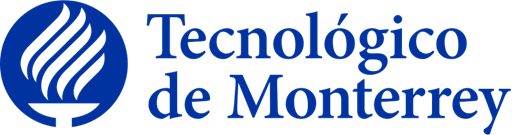


Maestría en Inteligencia Artificial Aplicada

Proyecto Integrador
Septiembre – Diciembre
2025

Actividad
Avance 5. Modelo final

Docentes:

*  Dra. Grettel Barceló Alonso
*  Dra. Verónica Sandra Guzmán De Valle

Asesor:

*   Dr. Luis Eduardo Falcón

Alumno:
*   Carlos Enríquez Gorgonio
A01793102
  
Octubrebre 2025


Durante la actividad anterior, se aplicaron los siguientes modelos:<br>
•	Red Neuronal (MLP)  
•	Regresión Logística  
•	Random Forest  
•	SVM (SVC)  
•	KNN (k=5)
•	Árbol de Decisión  
•	Gaussian Naive Bayes
•	LightGBM  
<br>
Las pruebas y ajustes de parámetros realizados con esos modelos fueron entre otras:<br>
•	Reducir y aumentar el volumen de los datos, agrupando por años, de 3 en 3, la mitad y al final todo el dataset completo.<br>
•	Ajustar los features de nuestros pipelines, probando de 5 a 7 y 9 features.<br>
•	Ajustar el tipo de imputaciones y codificaciones para nuestras variables numéricas y nuestras variables categorías dentro de nuestros pipelines<br>
•	Para el modelo de red neuronal, se hicieron pruebas con el número de capas y la profundidad.<br>
•	Para el modelo de regresión logísticas pruebas con el número de iteraciones<br>
•	Para el árbol de decisión se hicieron pruebas ajustando la profundidad máxima para evitar sobre entrenamiento.<br>
<br>
Para esta actividad Final, se eligió trabajar con el modelo que nos proporciono la mejor exactitud, con un 68%, la red neuronal. Iniciamos la actividad con un dataset preprocesado de la siguiente forma:<br>
<br>
1.	Integra la ubicación de cada municipio.  (Unión de dos datasets)<br>
2.	Features de fecha convertidos a tipo fecha<br>
3.	Generacion de nuevos features “DIA”, “MES”, “AÑO”, a partir del feature “FECHA INICIO”<br>
4.	conversión a mayúsculas, eliminar signos yu acentos y espacios de  todos los registros de los features  'NOMBRE MUNICIPIO', 'PREDIO O PARAJE', 'CAUSA DEL INCENDIO', 'CAUSA ESPECIFICA', 'TIPO DE INCENDIO', 'TIPO DE VEGETACION'<br>


In [36]:
#!pip install scikit-plot

import folium #Mapa
import geopandas as gpd
import lightgbm as lgb
import locale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import re
import seaborn as sns
import unicodedata
import time
import matplotlib.pyplot as plt
#import scikitplot as skplt

from google.colab import drive

from IPython.display import display, HTML

from scipy.stats import skew, chi2_contingency

from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, BaggingClassifier,GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error,accuracy_score, classification_report, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, log_loss,ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder,label_binarize
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from statsmodels.tsa.seasonal import seasonal_decompose

from tabulate import tabulate

##En caso de que se requiera trabajar con los DataSets Originales

In [2]:
'''drive.mount('/content/drive')

#DataSet Principal
#file_path = '/mnt/DataSetFinal25_13_A.xlsx'
file_path = '/content/drive/MyDrive/DataSetFinal25_13_A.xlsx'
df = pd.read_excel(file_path, header=0,)
df.head(10)'''

"drive.mount('/content/drive')\n\n#DataSet Principal\n#file_path = '/mnt/DataSetFinal25_13_A.xlsx'\nfile_path = '/content/drive/MyDrive/DataSetFinal25_13_A.xlsx'\ndf = pd.read_excel(file_path, header=0,)\ndf.head(10)"

In [3]:
'''#DataSet de Municipios y Coordenadas
#nombre_archivo = '/mnt/poblacion.csv'
nombre_archivo = '/content/drive/MyDrive/poblacion.csv'
df_c = pd.read_csv(nombre_archivo, encoding='utf-8')
df_c['municipio'] = df_c['municipio'].str.upper()
df_c= df_c[df_c['entidad'] == 'Durango'].copy()
df_c.head(10)'''

"#DataSet de Municipios y Coordenadas\n#nombre_archivo = '/mnt/poblacion.csv'\nnombre_archivo = '/content/drive/MyDrive/poblacion.csv'\ndf_c = pd.read_csv(nombre_archivo, encoding='utf-8')\ndf_c['municipio'] = df_c['municipio'].str.upper()\ndf_c= df_c[df_c['entidad'] == 'Durango'].copy()\ndf_c.head(10)"

###Este es el DataSet con todo el preprrocesamiento e integracion de coordenadas

In [26]:

drive.mount('/content/drive')

#DataSet Principal
#file_path = '/mnt/DataSetFinal25_13_A.xlsx'
file_path = '/content/drive/MyDrive/DataSet_Definitivo_A.xlsx'
df = pd.read_excel(file_path, header=0,)
df.head(10)
df_act5 = df
df_elegido = df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dimensiones = df.shape
print(f"El DataFrame tiene: {dimensiones[0]} filas")
print(f"El DataFrame tiene: {dimensiones[1]} columnas")

El DataFrame tiene: 3750 filas
El DataFrame tiene: 14 columnas


In [6]:
faltantes = df.isna().sum()

porcentaje_faltantes = (faltantes / len(df)) * 100

resultado = pd.DataFrame({
    'Cantidad faltante': faltantes,
    'Porcentaje faltante': porcentaje_faltantes
})

print(resultado)

                    Cantidad faltante  Porcentaje faltante
TIPO DE INCENDIO                    1             0.026667
TIPO DE VEGETACION                  0             0.000000
CAUSA DEL INCENDIO                  0             0.000000
CAUSA ESPECIFICA                    0             0.000000
PREDIO O PARAJE                     0             0.000000
AÑO                                 9             0.240000
MES                                 9             0.240000
DIA                                 9             0.240000
FECHA INICIO                        9             0.240000
TOTAL HA                            0             0.000000
COSTO ESTIMADO                   2332            62.186667
NOMBRE MUNICIPIO                    0             0.000000
LONGITUD_MUNICIPIO                220             5.866667
LATITUD_MUNICIPIO                 220             5.866667


#Definimos el preprocesamiento para nuestro modelo final de Red Neuronal

In [7]:
features = [
    'TIPO DE INCENDIO',
    'TIPO DE VEGETACION',
    'CAUSA DEL INCENDIO',
    'CAUSA ESPECIFICA',#
    'PREDIO O PARAJE',#
    'AÑO',
    'MES',
    'TOTAL HA',#
    'COSTO ESTIMADO'#
]

target = 'NOMBRE MUNICIPIO'

X = df[features]
y_texto = df[target]
le = LabelEncoder()
y = le.fit_transform(y_texto)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
numerical_features = ['AÑO', 'MES','TOTAL HA','COSTO ESTIMADO']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'CAUSA DEL INCENDIO','PREDIO O PARAJE','CAUSA ESPECIFICA']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
pipeline_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(300),
        alpha=0.001,                 # Probamos alfas de .01, .1
        early_stopping=True,
        max_iter=1000,
        random_state=42
    ))
])

print("Entrenando Red Neuronal (MLP)...")
pipeline_mlp.fit(X_train, y_train)


y_pred_mlp = pipeline_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

print(f"Accuracy Red Neuronal (MLP): {accuracy_mlp:.4f}\n")

Entrenando Red Neuronal (MLP)...
Accuracy Red Neuronal (MLP): 0.6813



Hasta este momento  tenemos un modelo con un desempeño positivo para nuestro Target es el NOMBRE MUNICIPIO, de esta forma podemos conocer todas las caracteristicas que rodean los tipos de incendio que pueden ocurrir en unu determinado municio, esto permite saber la utilidad de los features que podemos "reciclar" para cada una de las predicciones que se requieran visualziar, es decir, poder hacer un algoritmo de switcheo por decirlo de alguna forma, que nos permita alternar caracteristicas y sus predicciones, para no solamente conocer el NOMBRE MUNICIPIO, sino por ejemplo tambien poder predecir el TIPO DE INCENDIO, o el TIPOD DE VEGETACIÓN, etc. Esto unicamente cambiano nuestro target, dentro de un modelo ya calibrado para estos features especificos.

Al momento, asados en las caracteristicas de eventos ocurridos podemos clasificar teniendo como enfoque las caracteristicas de los incendios en una determinada ubicación geografica.

##MODELO 2

Ahora nuestro enfoque es en la probabilidad de que ocurra un incendio en un determinado mes en un determinado municipio, para lo que usarmeo un esquema de pronostico mas simple, que ya no requiere tantos features que nos son utiles para el cumplimiento de nuestro objetivo del proyecto.

Para esta parte enfrentamos el reto de tener features especificos como TEMPERATURA, HUMEDAD PRECIPITACION Y VELOCIDAD DEL VIENTO, las cuales a este momento no se tienen, esto porque las caracteristicas actuales no son sifnigicativas en las predicciones, esceptuando TIPO DE VEGETACIÓN y PREDIO O PARAJE, estimando que por las caracteristicas y variaciones que surjen al juntarse mas de un predio en un evento, este feature tambien puede ser omitido.

Sin mebargo se ofreceran las metricas de exactitud mas altas disponibles al momento de entregar el proyecto.

#MODELO 2 DE PREDICCIÓN DE PROBABILIDAD POR MES

In [10]:
#conteos de incendios
df_conteo = df.groupby(['NOMBRE MUNICIPIO', 'AÑO', 'MES']).size().reset_index(name='N_INCENDIOS')

municipios = df['NOMBRE MUNICIPIO'].unique()
anios = df['AÑO'].unique()
meses = range(1, 13)

#  MultiIndex con  las combinaciones
idx = pd.MultiIndex.from_product(
    [municipios, anios, meses],
    names=['NOMBRE MUNICIPIO', 'AÑO', 'MES']
)
df_full_historial = pd.DataFrame(index=idx).reset_index()

# Fusionamos los conteos con el historial completo
df_modelo = pd.merge(
    df_full_historial,
    df_conteo,
    on=['NOMBRE MUNICIPIO', 'AÑO', 'MES'],
    how='left'
)

# Rellenamos con 0 los meses sin incendios
#Este punto es clave porque cuando hicimos el ejercicio por dia habia un desbalance horrible de clases, es un reto a resolver
df_modelo['N_INCENDIOS'] = df_modelo['N_INCENDIOS'].fillna(0)

# nuevo target binario
df_modelo['OCURRIO_INCENDIO'] = (df_modelo['N_INCENDIOS'] > 0).astype(int)

print("Datos re-estructurados listos para pronóstico:")
print(df_modelo.head())

Datos re-estructurados listos para pronóstico:
  NOMBRE MUNICIPIO     AÑO  MES  N_INCENDIOS  OCURRIO_INCENDIO
0     PUEBLO NUEVO  2025.0    1          1.0                 1
1     PUEBLO NUEVO  2025.0    2          2.0                 1
2     PUEBLO NUEVO  2025.0    3         16.0                 1
3     PUEBLO NUEVO  2025.0    4         23.0                 1
4     PUEBLO NUEVO  2025.0    5         24.0                 1


In [11]:
features_pronostico = ['NOMBRE MUNICIPIO', 'MES']
target_pronostico = 'OCURRIO_INCENDIO'

X = df_modelo[features_pronostico]
y = df_modelo[target_pronostico]

# MES categórico para OneHotEncoding
X['MES'] = X['MES'].astype(str)

# Se entrena con todos los años y se prueba con 2025
ultimo_anio = df_modelo['AÑO'].max()
X_train = X[df_modelo['AÑO'] < ultimo_anio]
X_test = X[df_modelo['AÑO'] == ultimo_anio]
y_train = y[df_modelo['AÑO'] < ultimo_anio]
y_test = y[df_modelo['AÑO'] == ultimo_anio]

#  preprocesador
preprocessor_pronostico = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_pronostico)
    ],
    remainder='passthrough'
)

# pipeline de pronóstico
pipeline_pronostico = Pipeline(steps=[
    ('preprocessor', preprocessor_pronostico),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Entrenar
print("\nEntrenando modelo de pronóstico...")
pipeline_pronostico.fit(X_train, y_train)

# Evaluar
y_pred = pipeline_pronostico.predict(X_test)
print(classification_report(y_test, y_pred))


Entrenando modelo de pronóstico...
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       265
           1       0.72      0.95      0.82        59

    accuracy                           0.92       324
   macro avg       0.85      0.93      0.88       324
weighted avg       0.94      0.92      0.93       324



/tmp/ipython-input-1817473192.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['MES'] = X['MES'].astype(str)


In [12]:
#  DataFrame PARA FECHAS FUTURAS
anio_futuro = ultimo_anio + 1 # o 2026
municipios = df['NOMBRE MUNICIPIO'].unique()
meses = [str(m) for m in range(1, 13)] # MES es string

idx_futuro = pd.MultiIndex.from_product(
    [municipios, meses],
    names=['NOMBRE MUNICIPIO', 'MES']
)
df_futuro = pd.DataFrame(index=idx_futuro).reset_index()

# [:, 1] selecciona la probabilidad de la clase "1" (OCURRIO_INCENDIO)
probabilidades_futuro = pipeline_pronostico.predict_proba(df_futuro)[:, 1]

#Añadir probabilidades al DataFrame
df_futuro['PROBABILIDAD_INCENDIO (%)'] = probabilidades_futuro * 100

#  resultados
df_futuro_ordenado = df_futuro.sort_values(by='PROBABILIDAD_INCENDIO (%)', ascending=False)

print(f"\n--- Probabilidades de Incendio para {anio_futuro} ---")
print(df_futuro_ordenado.head(15))

# AQUI PODEMOS PONER EL MES NO EN STRING COMO LO TRRAEMOS, SINO POR NUMERO, Y EL MUNICIPIO QUE QUEREMOS PROBAR
print("\n--- Probabilidad para 'DURANGO' en el mes 4 (Abril) ---")
prob_dgo_abr = df_futuro[
    (df_futuro['NOMBRE MUNICIPIO'] == 'DURANGO') &
    (df_futuro['MES'] == '1')
]
print(prob_dgo_abr)


--- Probabilidades de Incendio para 2026.0 ---
        NOMBRE MUNICIPIO MES  PROBABILIDAD_INCENDIO (%)
28               DURANGO   5                  98.666359
4           PUEBLO NUEVO   5                  98.428575
27               DURANGO   4                  97.890172
3           PUEBLO NUEVO   4                  97.517479
88             MEZQUITAL   5                  97.425738
29               DURANGO   6                  97.367687
76             SAN DIMAS   5                  97.014466
5           PUEBLO NUEVO   6                  96.905616
26               DURANGO   3                  96.542059
64  SANTIAGO PAPASQUIARO   5                  96.312040
87             MEZQUITAL   4                  95.957090
2           PUEBLO NUEVO   3                  95.941101
75             SAN DIMAS   4                  95.322448
40            TEPEHUANES   5                  95.024665
89             MEZQUITAL   6                  94.980437

--- Probabilidad para 'DURANGO' en el mes 4 (Abril) ---

#OBSERVACIONES
Hasta este momento la exactitud es elevada debido a que responde la probabilidad de que un incendio ocurra en un mes determinado en un municipio determinado, esto mayormente reforzado gracias a que solo se tienen 12 valores, pero el reto mayor es lograr hacerlo por dia, e incluso por hora. Para eso se necesitan mayores features como Temperatura, Humedad, Precipitación, Dirección del Aire, etc.

#Comparativo de Modelos de la Actividad 4<br>

Los modelos previamente probados fueron:<br>
•	Red Neuronal (MLP)  <br>
•	Regresión Logística  <br>
•	Random Forest  <br>
•	SVM (SVC)  <br>
•	KNN (k=5)<br>
•	Árbol de Decisión  <br>
•	Gaussian Naive Bayes <br>
•	LightGBM  <br>
<br>
A continuación se muestran los comparativos mas relevantes de la actividad anterior, cabe señalar que se hicieron muchas pruebas, sin embargo unicamente se ponen las que causaron cambios mas significativos, los cuales fueron añadir  caracteristicas, bajo determinadas condiciones.<br>

Una observación es que por mucho tiempo los resultados oscilaban alrededor del 40% de exactitud y precision, se tuvo un enfoque porincipal en los hiperparametrros de la Red Neuronal, pero no habia variaciones consistentes, sin embargo, aunque hay varibles desbalanceadas en algunas caracteristicas añadidas, con la imputación correcta, se logro mejorar el modelo con los 3 mejores resultados que se muestran a continuacion:<br>


Prueba 1.-<br>
numerical_features = ['AÑO', 'MES',]<br>
categorical_features = ['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'CAUSA DEL INCENDIO']<br>
<br>
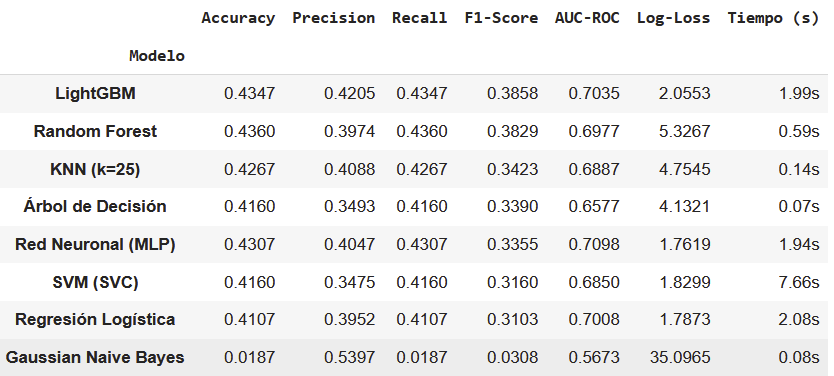 <br>

#***************************************************************************<br>
Prueba 2.-<br>
numerical_features = ['AÑO', 'MES','TOTAL HA'] <br>
categorical_features = ['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'CAUSA DEL INCENDIO','PREDIO O PARAJE']<br>
<br>

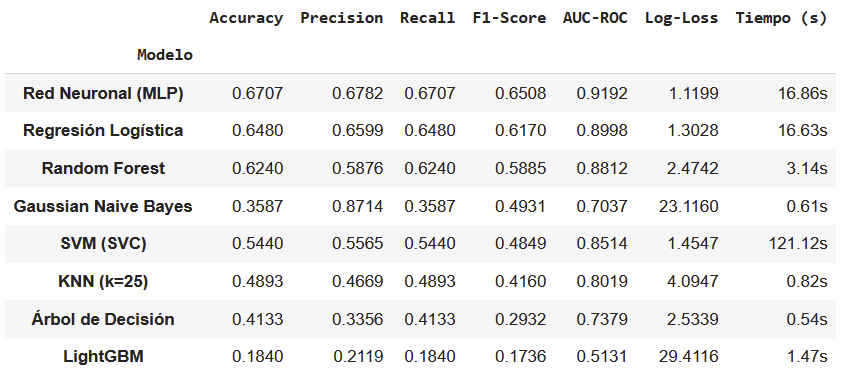

#************************************************************************ <br>
Prueba 3.-<br>
numerical_features = ['AÑO', 'MES','TOTAL HA','COSTO ESTIMADO'] <br>
categorical_features = ['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'CAUSA DEL INCENDIO','PREDIO O PARAJE','CAUSA ESPECIFICA'] <br>
<br>
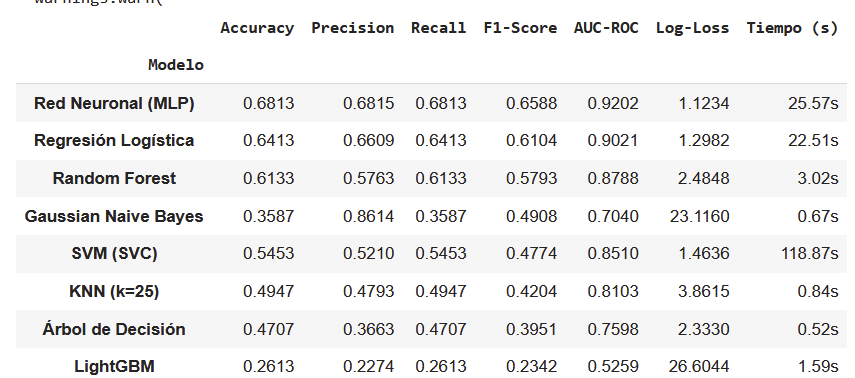

#Comparativo de Modelos de la Actividad <br>

Los modelos previamente probados fueron:<br>
•	Red Neuronal (MLP)  <br>
•	Regresión Logística  <br>

Restauramos nuestro DataFrame

In [19]:
df = df_act5

In [20]:
features = [
    'TIPO DE INCENDIO',
    'TIPO DE VEGETACION',
    'CAUSA DEL INCENDIO',
    #'CAUSA ESPECIFICA',# Solo se quita para la prueba 3 y se regresa
    #'PREDIO O PARAJE',# Solo se quita para la prueba 3 y se regresa
    'AÑO',
    'MES',
    'TOTAL HA',#
    'COSTO ESTIMADO'#
]

target = 'NOMBRE MUNICIPIO'

X = df[features]
y_texto = df[target]
le = LabelEncoder()
y = le.fit_transform(y_texto)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_features = ['AÑO', 'MES','TOTAL HA','COSTO ESTIMADO']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#categorical_features = ['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'CAUSA DEL INCENDIO','PREDIO O PARAJE','CAUSA ESPECIFICA']
categorical_features = ['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'CAUSA DEL INCENDIO'] #Este es solo para la prueba 3

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [21]:

def calcular_metricas(modelo_nombre, y_test, y_pred, y_pred_proba, start_time, all_classes):
    #'weighted' average para métricas multiclase
    #'labels' evita errores si y_test no tiene todas las clases.

    # Métricas para Multiclase
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Métricas de probabilidad
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted', labels=all_classes)
    logloss = log_loss(y_test, y_pred_proba, labels=all_classes)

    tiempo = time.time() - start_time

    print(f"Resultados de {modelo_nombre}: Accuracy={accuracy:.4f}, F1={f1:.4f}, Tiempo={tiempo:.2f}s")

    return {
        "Modelo": modelo_nombre,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "Log-Loss": logloss,
        "Tiempo (s)": tiempo
    }

# 0  MLP Original ---
def entrenar_mlp_original(X_train, y_train, X_test, y_test, preprocessor):
    print("Entrenando MLP)")
    start_time = time.time()

    pipeline_mlp = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(
            #hidden_layer_sizes=(300), # (100, 100), (500)
            hidden_layer_sizes=(400,100),
            alpha=0.001,              # Penalización 0.01, 0.0001
            learning_rate_init=0.001,
            early_stopping=True,
            max_iter=1000,
            random_state=42
        ))
    ])

    pipeline_mlp.fit(X_train, y_train)

    y_pred = pipeline_mlp.predict(X_test)
    y_pred_proba = pipeline_mlp.predict_proba(X_test)

    return calcular_metricas("MLP (Original)", y_test, y_pred, y_pred_proba, start_time, pipeline_mlp.classes_)

# 1 Homogéneo Bagging
def entrenar_random_forest(X_train, y_train, X_test, y_test, preprocessor):
    print("Entrenando Random Forest")
    start_time = time.time()

    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            #n_estimators=100,       # Número de árboles 200, 500.
            n_estimators=300,
            #max_depth=None,         # Profundidad 10, 20.
            max_depth=3,
            min_samples_leaf=1,     #  5, 10.
            random_state=42,
            n_jobs=-1
        ))
    ])

    pipeline_rf.fit(X_train, y_train)

    y_pred = pipeline_rf.predict(X_test)
    y_pred_proba = pipeline_rf.predict_proba(X_test)

    return calcular_metricas("Random Forest Bagging", y_test, y_pred, y_pred_proba, start_time, pipeline_rf.classes_)

# 2: Homogéneo Boosting
def entrenar_gradient_boosting(X_train, y_train, X_test, y_test, preprocessor):
    print("Entrenando Gradient Boosting")
    start_time = time.time()

    pipeline_gb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(
            #n_estimators=100,       # Número de árboles 200, 500.
            n_estimators=200,
            learning_rate=0.1,      # Tasa  0.05, 0.2.
            max_depth=3,            # Profundidad  5, 7.
            random_state=42
        ))
    ])

    pipeline_gb.fit(X_train, y_train)

    y_pred = pipeline_gb.predict(X_test)
    y_pred_proba = pipeline_gb.predict_proba(X_test)

    return calcular_metricas("Gradient Boosting", y_test, y_pred, y_pred_proba, start_time, pipeline_gb.classes_)

# 3 Heterogéneo Stacking
def entrenar_stacking(X_train, y_train, X_test, y_test, preprocessor):
    print("EntrenandoStacking")
    start_time = time.time()

    # Base 1: Regresión Logística (modelo lineal)
    base_lr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Base 2: Random Forest (modelo de bagging)
    base_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)) #POodemos ajustar los arboles tambien aqui es independiente
    ])

    # Base 3: MLP Original (modelo de red neuronal)
    base_mlp = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(
            #hidden_layer_sizes=(300),
            hidden_layer_sizes=(400,100),
            alpha=0.001,
            early_stopping=True,
            max_iter=1000,
            random_state=42
        ))
    ])

    # Lista de estimadores base
    estimators = [
        ('log_reg', base_lr),
        ('rand_forest', base_rf),
        ('mlp', base_mlp)
    ]

    #  Meta-Modelo
    final_estimator = LogisticRegression(max_iter=1000)

    # StackingClassifier
    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1,
        passthrough=False # poner tru True para usar los datos originales
    )

    stacking_model.fit(X_train, y_train)

    y_pred = stacking_model.predict(X_test)
    y_pred_proba = stacking_model.predict_proba(X_test)

    return calcular_metricas("Stacking (RF+LR+MLP)", y_test, y_pred, y_pred_proba, start_time, stacking_model.classes_)


#Función de llamado a ejecución general

def ejecutar_comparativa_ensambles(X_train, y_train, X_test, y_test, preprocessor):

    resultados = []

    resultados.append(entrenar_mlp_original(X_train, y_train, X_test, y_test, preprocessor))
    resultados.append(entrenar_random_forest(X_train, y_train, X_test, y_test, preprocessor))
    resultados.append(entrenar_gradient_boosting(X_train, y_train, X_test, y_test, preprocessor))
    resultados.append(entrenar_stacking(X_train, y_train, X_test, y_test, preprocessor))

    df_resultados = pd.DataFrame(resultados).set_index("Modelo")
    df_resultados = df_resultados.sort_values(by="F1-Score", ascending=False)

    df_formateado = df_resultados.style.format({
        "Accuracy": "{:.4f}",
        "Precision": "{:.4f}",
        "Recall": "{:.4f}",
        "F1-Score": "{:.4f}",
        "AUC-ROC": "{:.4f}",
        "Log-Loss": "{:.4f}",
        "Tiempo (s)": "{:.2f}s"
    })

    return df_formateado

In [22]:
tabla_comparativa = ejecutar_comparativa_ensambles(
    X_train,
    y_train,
    X_test,
    y_test,
    preprocessor
)

print("\n\n--- TABLA COMPARATIVA DE MODELOS ---")
display(tabla_comparativa)

Entrenando MLP)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

Resultados de MLP (Original): Accuracy=0.4240, F1=0.3320, Tiempo=4.67s
Entrenando Random Forest


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

Resultados de Random Forest Bagging: Accuracy=0.3640, F1=0.1943, Tiempo=1.03s
Entrenando Gradient Boosting
Resultados de Gradient Boosting: Accuracy=0.4360, F1=0.3985, Tiempo=27.95s
EntrenandoStacking


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

Resultados de Stacking (RF+LR+MLP): Accuracy=0.4507, F1=0.3831, Tiempo=13.79s


--- TABLA COMPARATIVA DE MODELOS ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Log-Loss,Tiempo (s)
Modelo,,,,,,,
Gradient Boosting,0.4360,0.4026,0.4360,0.3985,0.7122,2.3446,27.95s
Stacking (RF+LR+MLP),0.4507,0.3771,0.4507,0.3831,0.7320,1.7463,13.79s
MLP (Original),0.4240,0.3260,0.4240,0.3320,0.6949,1.8256,4.67s
Random Forest Bagging,0.3640,0.1325,0.3640,0.1943,0.6900,1.8878,1.03s


##Prueba 1
<br>
<br>

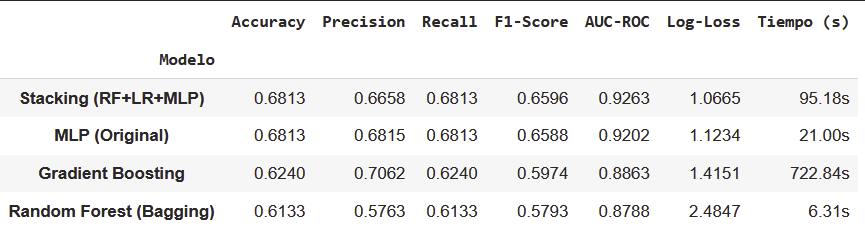

<br>
<br>
#Prueba 2
<br>
<br>
- Al modelo Red Neuronal, le Añadimos una capa adicional<br>
hidden_layer_sizes=(400,100)<br>
- Al bosque aleatorio, le aumentamos la cantidad de estimadores, y le configuramos una profundidad simple de 3<br>
n_estimators=300<br>
- A nuestro gradien booster duplicamos el número de arboles<br>
n_estimators=200<br>
- A nuestro stacking, también le ajustamos lo mismo que nuestra red neuronal<br>
<br>
<br>

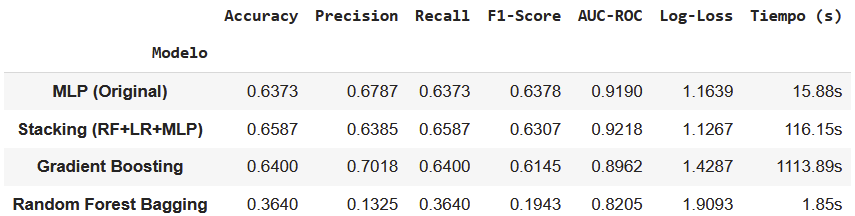


<br>
<br>

#Prueba 3
Removiendo  2 featuures de alta cardinalidad: PREIO O PARAJE y CAUSA ESPECIFICA
<br>
<br>
Se observa el mismo comportamiento del ejercicio de la actividad 4, que oscilaba en exactitudes aproximadas al 40, y el cambio principial consiste en aññadir los features.

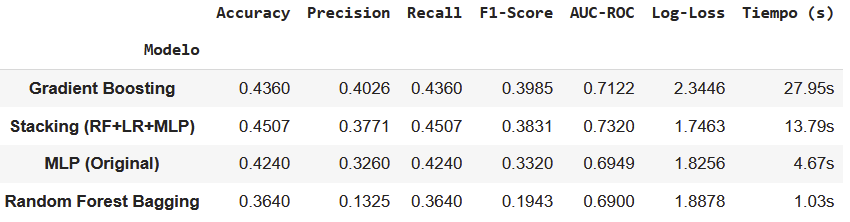




#MODELO ELEGIDO<br>
<br>

Red Neuuronal Original
<br>

In [27]:
df = df_elegido

In [28]:
features = [
    'TIPO DE INCENDIO',
    'TIPO DE VEGETACION',
    'CAUSA DEL INCENDIO',
    'CAUSA ESPECIFICA',#
    'PREDIO O PARAJE',#
    'AÑO',
    'MES',
    'TOTAL HA',#
    'COSTO ESTIMADO'#
]

target = 'NOMBRE MUNICIPIO'

X = df[features]
y_texto = df[target]
le = LabelEncoder()
y = le.fit_transform(y_texto)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['AÑO', 'MES','TOTAL HA','COSTO ESTIMADO']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['TIPO DE INCENDIO', 'TIPO DE VEGETACION', 'CAUSA DEL INCENDIO','PREDIO O PARAJE','CAUSA ESPECIFICA']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
pipeline_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(300),
        alpha=0.001,                 # Probamos alfas de .01, .1
        early_stopping=True,
        max_iter=1000,
        random_state=42
    ))
])

print("Entrenando Red Neuronal (MLP)...")
pipeline_mlp.fit(X_train, y_train)


y_pred_mlp = pipeline_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

print(f"Accuracy Red Neuronal (MLP): {accuracy_mlp:.4f}\n")

Entrenando Red Neuronal (MLP)...
Accuracy Red Neuronal (MLP): 0.6813



In [37]:
# Probabilidades para la curvas ROC y PR
#y_pred_proba_mlp = pipeline_mlp.predict_proba(X_test)
#class_names = le.classes_
y_pred_mlp = pipeline_mlp.predict(X_test)
y_pred_proba_mlp = pipeline_mlp.predict_proba(X_test)
class_names = le.classes_
n_classes = len(class_names)
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

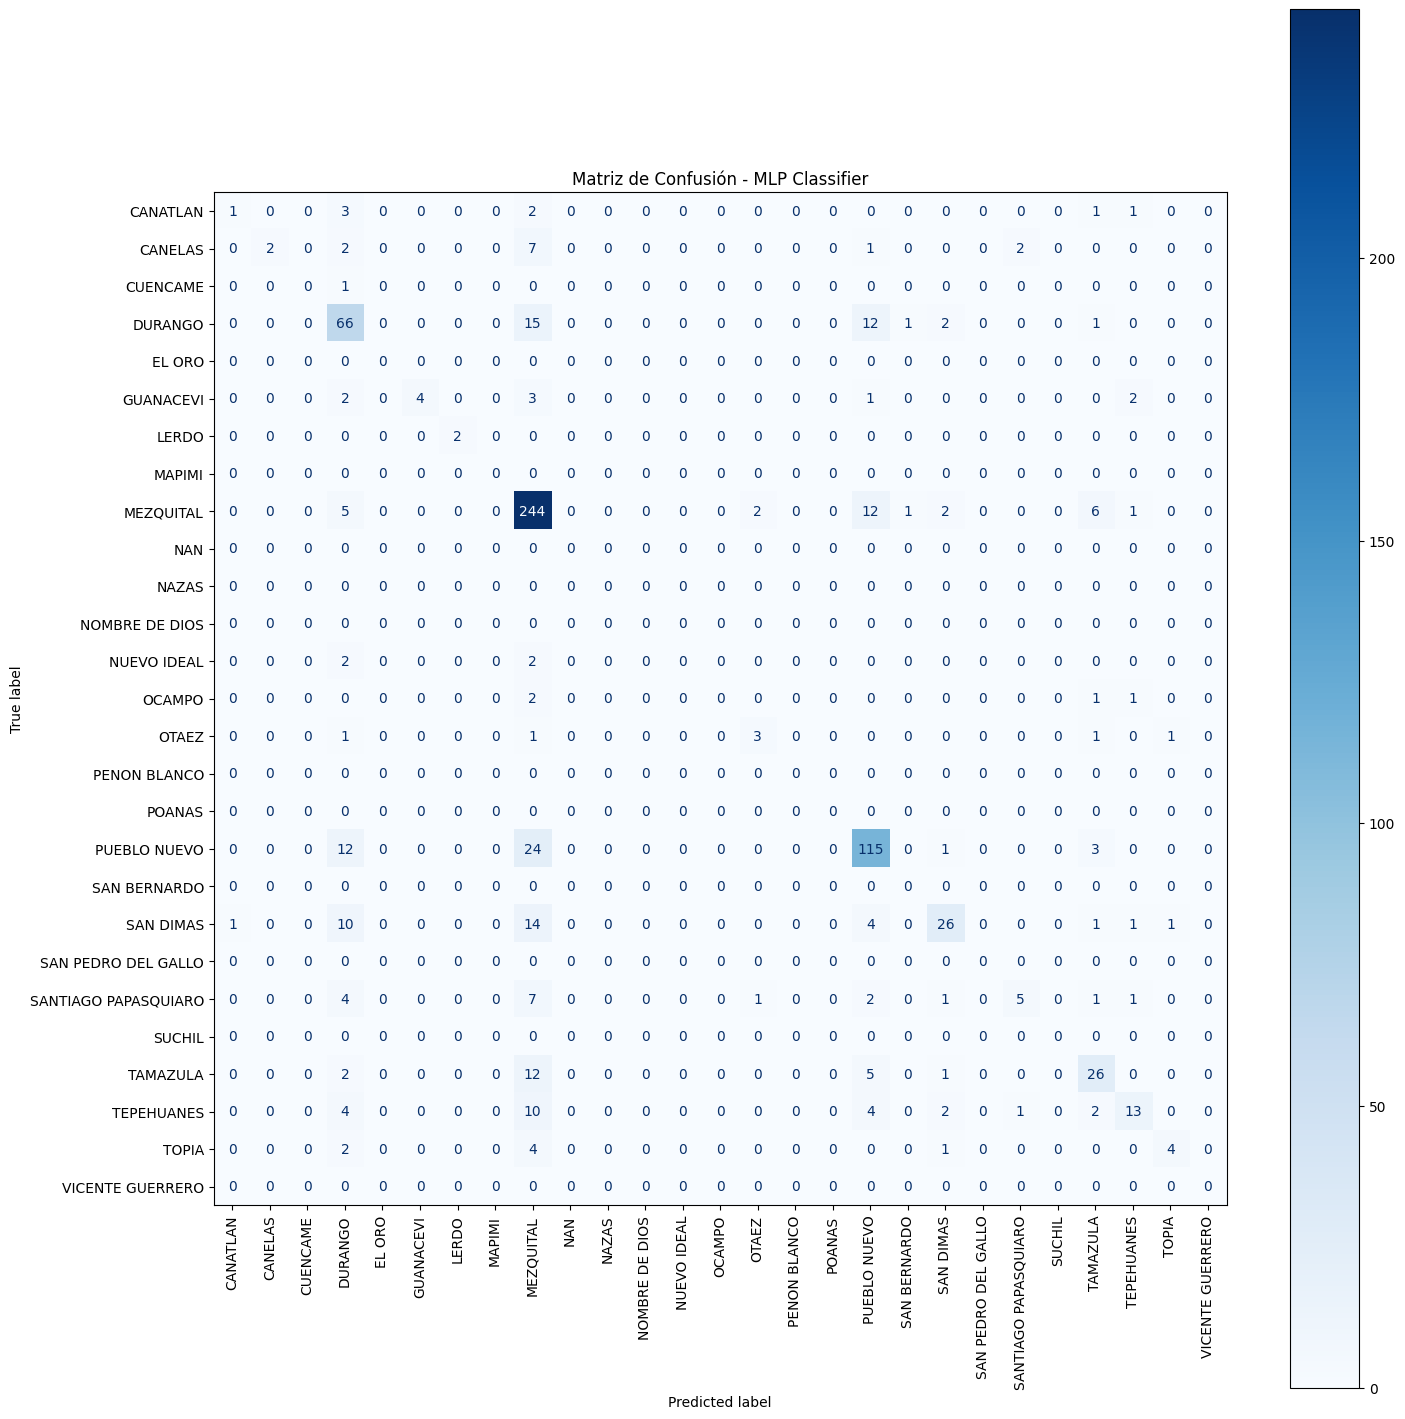

In [39]:
# MATRIZ DE CONFUSIÓN
fig, ax = plt.subplots(figsize=(15, 15))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_mlp,
    labels=np.arange(n_classes),
    display_labels=class_names, #  nombres de los municipios
    ax=ax,
    cmap='Blues',               # color
    xticks_rotation='vertical'
)

ax.set_title("Matriz de Confusión - MLP Classifier")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ran

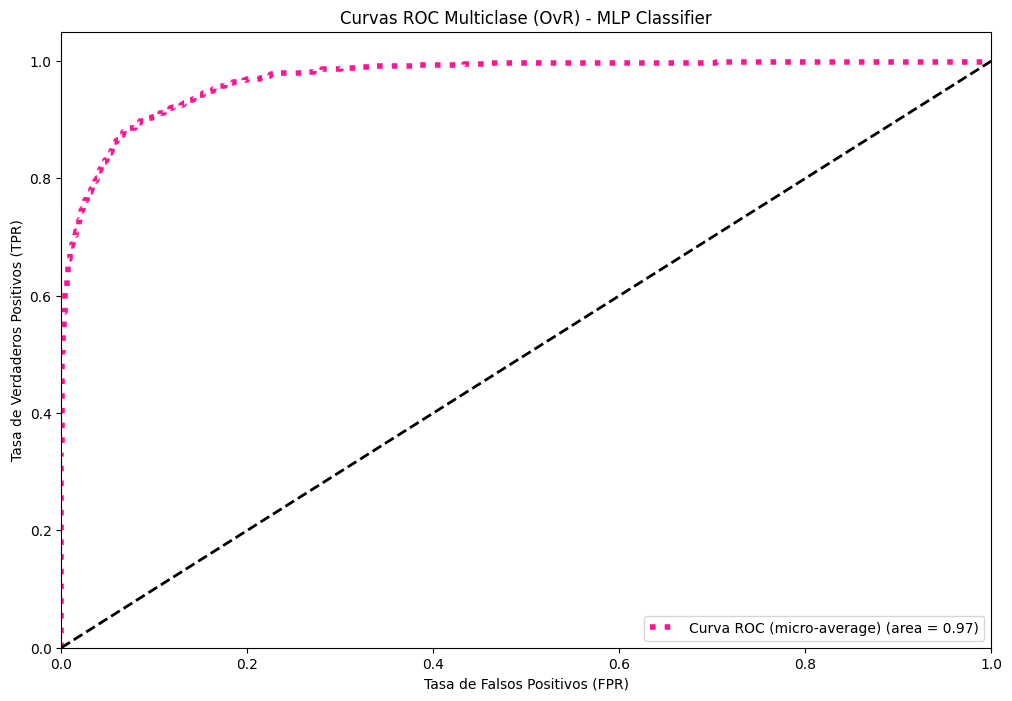

In [40]:

# CURVA AUC.ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular ROC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 2. Calcular ROC promedio global
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba_mlp.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Curva ROC (micro-average) (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Línea de azar
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Multiclase (OvR) - MLP Classifier')
plt.legend(loc="lower right")
plt.show()

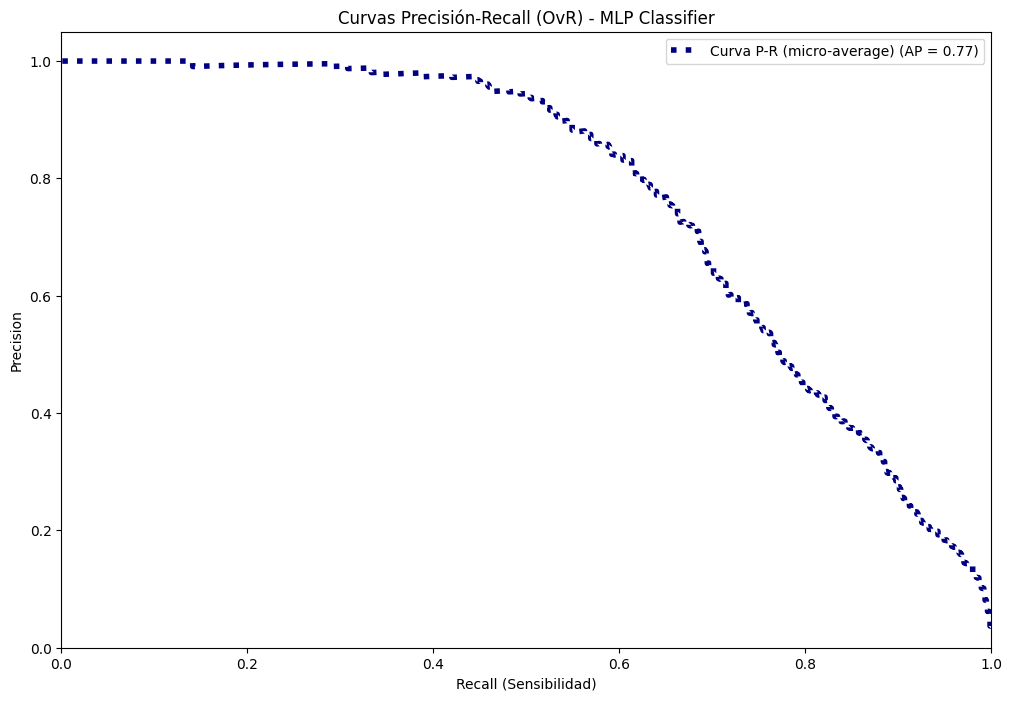

In [41]:
# Precisión-Recall
precision = dict()
recall = dict()
avg_precision = dict()

#Calcular PR
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_binarized.ravel(), y_pred_proba_mlp.ravel()
)
avg_precision["micro"] = average_precision_score(y_test_binarized, y_pred_proba_mlp, average="micro")
plt.figure(figsize=(12, 8))

plt.plot(recall["micro"], precision["micro"],
         label=f'Curva P-R (micro-average) (AP = {avg_precision["micro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Curvas Precisión-Recall (OvR) - MLP Classifier')
plt.legend(loc="upper right")
plt.show()

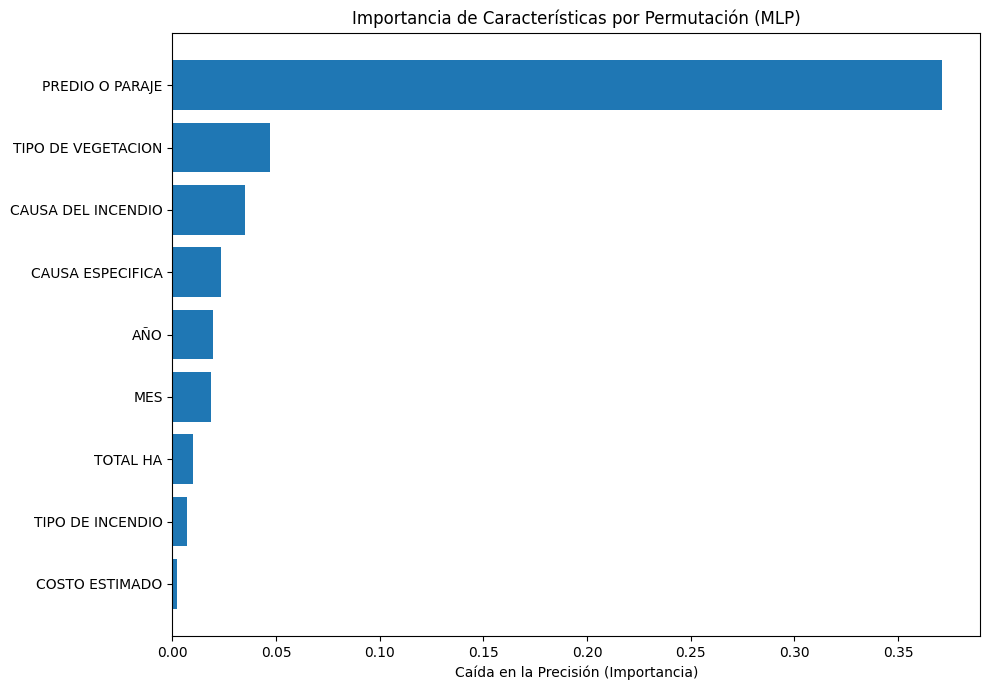

In [43]:

# fEATURE iMPORTANCE
r = permutation_importance(
    pipeline_mlp,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

feature_names = X_test.columns
sorted_idx = r.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.barh(
    feature_names[sorted_idx],
    r.importances_mean[sorted_idx]
)
plt.xlabel("Caída en la Precisión (Importancia)")
plt.title("Importancia de Características por Permutación (MLP)")
plt.tight_layout()
plt.show()